# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [28]:
# Requirements
!pip install yahoo_fin

In [29]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [30]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3, 4, 5]

# Stock ticker, MSFT
STOCK = 'MSFT'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [31]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
je38746n_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [32]:
je38746n_df.head()

,open,high,low,close,adjclose,volume,ticker
2021-05-07,252.149994,254.300003,251.169998,252.460007,245.968658,27032900,MSFT
2021-05-10,250.869995,251.729996,247.119995,247.179993,240.824387,29299900,MSFT
2021-05-11,244.550003,246.600006,242.570007,246.229996,239.898834,33641600,MSFT
2021-05-12,242.169998,244.380005,238.070007,239.000000,232.854721,36684400,MSFT
2021-05-13,241.800003,245.600006,241.419998,243.029999,236.781097,29624300,MSFT


In [33]:
!date

Wed May 15 02:05:03 AM UTC 2024


In [34]:
%connect_info

{
  "shell_port": 1,
  "iopub_port": 2,
  "stdin_port": 3,
  "control_port": 4,
  "hb_port": 5,
  "ip": "/root/.local/share/jupyter/runtime/kernel-797b4fd2-3537-423b-ae4d-86a76afe77ea-ipc",
  "key": "",
  "transport": "ipc",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-797b4fd2-3537-423b-ae4d-86a76afe77ea.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [35]:
# remove columns which our neural network will not use
je38746n_df = je38746n_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
je38746n_df['date'] = je38746n_df.index

In [36]:
je38746n_df

,close,date
2021-05-07,252.460007,2021-05-07
2021-05-10,247.179993,2021-05-10
2021-05-11,246.229996,2021-05-11
2021-05-12,239.000000,2021-05-12
2021-05-13,243.029999,2021-05-13
...,...,...
2024-05-08,410.540009,2024-05-08
2024-05-09,412.320007,2024-05-09
2024-05-10,414.739990,2024-05-10
2024-05-13,413.720001,2024-05-13


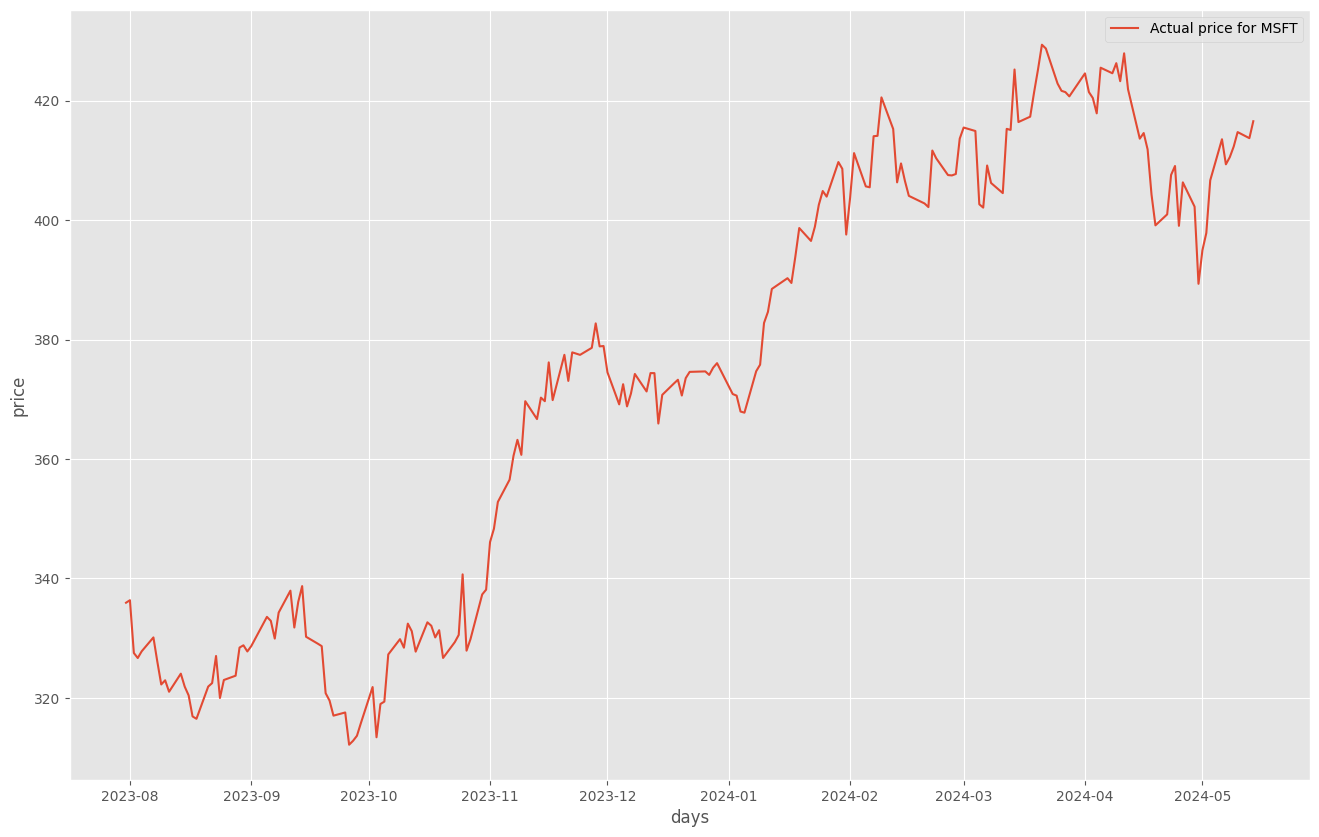

In [37]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(je38746n_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [38]:
# Scale data for ML engine
scaler = MinMaxScaler()
je38746n_df['scaled_close'] = scaler.fit_transform(np.expand_dims(je38746n_df['close'].values, axis=1))

In [39]:
je38746n_df

,close,date,scaled_close
2021-05-07,252.460007,2021-05-07,0.177622
2021-05-10,247.179993,2021-05-10,0.153077
2021-05-11,246.229996,2021-05-11,0.148661
2021-05-12,239.000000,2021-05-12,0.115052
2021-05-13,243.029999,2021-05-13,0.133786
...,...,...,...
2024-05-08,410.540009,2024-05-08,0.912468
2024-05-09,412.320007,2024-05-09,0.920742
2024-05-10,414.739990,2024-05-10,0.931991
2024-05-13,413.720001,2024-05-13,0.927250


In [40]:
def PrepareData(days):
  df = je38746n_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [41]:
PrepareData(5) # 5 days

(                 close       date  scaled_close    future
 2021-05-07  252.460007 2021-05-07      0.177622  0.157586
 2021-05-10  247.179993 2021-05-10      0.153077  0.143780
 2021-05-11  246.229996 2021-05-11      0.148661  0.134018
 2021-05-12  239.000000 2021-05-12      0.115052  0.134204
 2021-05-13  243.029999 2021-05-13      0.133786  0.149823
 ...                ...        ...           ...       ...
 2024-05-01  394.940002 2024-05-01      0.839950  0.912468
 2024-05-02  397.839996 2024-05-02      0.853431  0.920742
 2024-05-03  406.660004 2024-05-03      0.894431  0.931991
 2024-05-06  413.540009 2024-05-06      0.926413  0.927250
 2024-05-07  409.339996 2024-05-07      0.906889  0.940452
 
 [755 rows x 4 columns],
 array([[0.8739309 ],
        [0.81387126],
        [0.83994985],
        [0.8534306 ],
        [0.89443105],
        [0.92641324],
        [0.9068892 ],
        [0.91246754],
        [0.920742  ],
        [0.9319914 ],
        [0.9272499 ],
        [0.94045186]], 

In [43]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [44]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 4s 6ms/step - loss: 0.0159
Epoch 2/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 3/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0038
Epoch 4/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0029
Epoch 5/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 6/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 7/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 8/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 9/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 10/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 11/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 12/80
95/95 [==============================] - 1s 6ms/step - loss: 0.0019
Epoch 13/80
95/95 [==============================

1/1 [==============================] - 1s 653ms/step
Epoch 1/80
94/94 [==============================] - 5s 6ms/step - loss: 0.0153
Epoch 2/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 3/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 4/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0047
Epoch 5/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 6/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0046
Epoch 7/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 8/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 9/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0044
Epoch 10/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 11/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 12/80
94/94 [==============================] - 1s 6ms/step - loss: 0.0

1/1 [==============================] - 1s 609ms/step


In [45]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 5 days ({predictions_str})'

  print(message)

MSFT prediction for upcoming 5 days (406.5$, 426.04$, 419.5$, 410.48$, 411.42$)


In [46]:
# Execute model for the whole history range
copy_je38746n_df = je38746n_df.copy()

# Execute model for the whole history range
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:8], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_je38746n_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 3ms/step


In [47]:
copy_je38746n_df

,close,date,scaled_close,predicted_close
2021-05-07,252.460007,2021-05-07,0.177622,250.779999
2021-05-10,247.179993,2021-05-10,0.153077,251.720001
2021-05-11,246.229996,2021-05-11,0.148661,251.490005
2021-05-12,239.000000,2021-05-12,0.115052,249.309998
2021-05-13,243.029999,2021-05-13,0.133786,249.679993
...,...,...,...,...
2024-05-08,410.540009,2024-05-08,0.912468,403.694000
2024-05-09,412.320007,2024-05-09,0.920742,404.990204
2024-05-10,414.739990,2024-05-10,0.931991,414.739990
2024-05-13,413.720001,2024-05-13,0.927250,413.720001


In [50]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)
date_day4 = dt.date.today() + dt.timedelta(days=3)
date_day5 = dt.date.today() + dt.timedelta(days=4)

copy_je38746n_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_je38746n_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_je38746n_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]
copy_je38746n_df.loc[date_day4] = [predictions[3], f'{date_day4}', 0, 0]
copy_je38746n_df.loc[date_day5] = [predictions[4], f'{date_day5}', 0, 0]

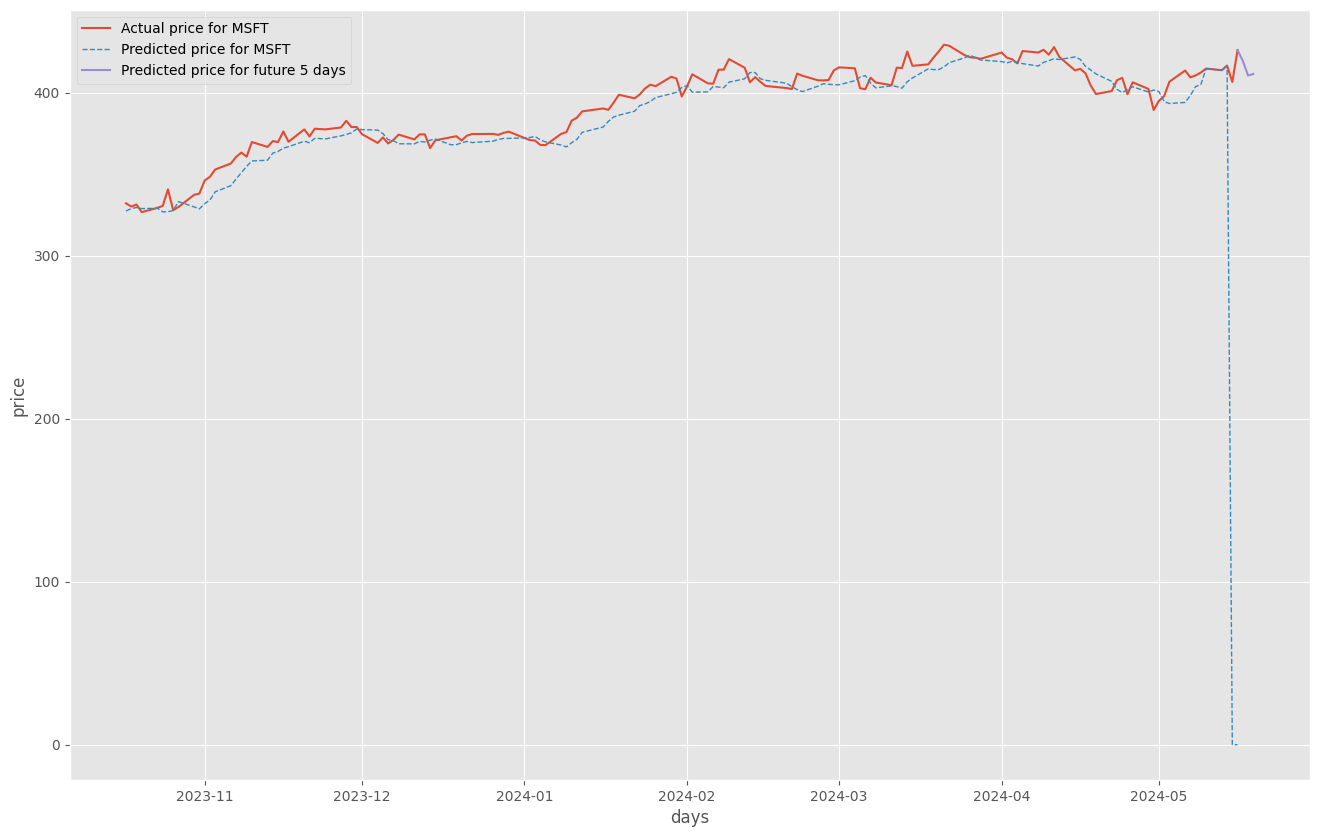

In [51]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_je38746n_df['close'][-150:].head(147))
plt.plot(copy_je38746n_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_je38746n_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 5 days'])
plt.show()